In [1]:
# Импорт библиотек
from pathlib import Path
from warnings import filterwarnings
import os
import sys

from IPython.display import display, Markdown
from matplotlib import pyplot as plt
from tqdm import tqdm
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel


#from arch import arch_model
from surprise import Dataset
from surprise import Reader
from surprise.dataset import BUILTIN_DATASETS #с помощью данного объекта мы можем использовать встроенные датасеты
from surprise.model_selection import train_test_split
from surprise import SVD, KNNBasic, accuracy
from surprise import BaselineOnly

from scipy.sparse import csr_matrix
from scipy.optimize import minimize, least_squares


from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import precision_at_k, recall_at_k

import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import scipy
import sklearn

import time

# Попытка применить ускорение Intel Extension для scikit-learn
try:
    from sklearnex import patch_sklearn, config_context
    patch_sklearn()
    print('Intel Extension для scikit-learn успешно активирован')
except (ImportError, ModuleNotFoundError, Exception) as e:
    print(f'Не удалось активировать Intel Extension для scikit-learn: {e}')
    print(f'Продолжаем работу без ускорения (это нормально)')

Intel Extension для scikit-learn успешно активирован


Extension for Scikit-learn* enabled (https://github.com/uxlfoundation/scikit-learn-intelex)


In [2]:
filterwarnings("ignore")
# warnings.filterwarnings('ignore', category=UserWarning)
# warnings.filterwarnings('ignore', message='.*ConvergenceWarning.*')

plt.style.use('seaborn-v0_8') #стиль отрисовки seaborn
sns.set_style("whitegrid")
%matplotlib inline


SEED = 42

# Проверка текущей рабочей директории
print(f"Текущая рабочая директория: {os.getcwd()}")

# Текущая рабочая директория (скорее всего .../IDE)
current_dir = os.getcwd()

# Относительный путь от корня проекта до папки с ноутбуком
# Обратите внимание: используем r'' для корректной обработки слешей и пробелов
relative_path_to_notebook = r'skillfactory/MATH_ML_15'

# Проверяем, не перешли ли мы уже в нужную папку (чтобы не было ошибок при перезапуске ячейки)
if not current_dir.endswith("MATH_ML_15"):
    # Собираем полный путь
    new_dir = os.path.join(current_dir, relative_path_to_notebook)
    
    # Меняем рабочую директорию
    try:
        os.chdir(new_dir)
        print(f"Рабочая директория изменена на: {os.getcwd()}")
    except FileNotFoundError:
        print("Ошибка: путь не найден. Проверьте правильность названий папок.")
else:
    print("Рабочая директория уже верная.")

Текущая рабочая директория: /home/pavel/IDE
Рабочая директория изменена на: /home/pavel/IDE/skillfactory/MATH_ML_15


# 4. Гибридные модели

Гибридная РС — это особый тип рекомендательной системы, который представляет собой комбинацию из нескольких методов. Обычно это комбинация контентного подхода и коллаборативной фильтрации. Такое сочетание может помочь преодолеть недостатки, с которыми мы сталкиваемся при использовании этих методов по отдельности, а также в некоторых случаях может быть более эффективным.

Гибридные подходы к рекомендательным системам можно реализовать по-разному, например используя комбинацию из рекомендаций, полученных обеими системами, или используя взвешенную сумму предсказанных рейтингов.

Давайте на практике рассмотрим, как создать рекомендательную систему с помощью гибридного подхода.

Разумеется, можно комбинировать различные подходы самостоятельно, однако для удобства уже реализован модуль LightFM — установим библиотеку через следующую команду:

!pip install lightfm
Примечание. К сожалению, при локальном использовании данной библиотеки очень часто возникают ошибки. Если вы столкнулись с этим, рекомендуем использовать Google Colab.

Импортируем нужные нам функции из этой библиотеки. На этом этапе сразу же загрузим инструменты оценки модели:


In [3]:
# from lightfm import LightFM
# from lightfm.cross_validation import random_train_test_split
# from lightfm.evaluation import precision_at_k, recall_at_k

Работать мы будем с датасетом goodreads_book.

Goodreads — это сайт, на котором люди могут добавлять книги в каталоги, искать их, изучать аннотации и отзывы. Пользователи также могут создавать сообщества, в которых они рекомендуют друг другу различную литературу, ведут блоги и устраивают обсуждения.

Подгрузим все файлы, относящиеся к этому набору данных:

In [4]:
ratings = pd.read_csv('./data/Gooddreadbooks/ratings.csv') # Поставленные оценки
books = pd.read_csv('./data/Gooddreadbooks/books.csv') # Информация о книгах
tags = pd.read_csv('./data/Gooddreadbooks/tags.csv') # Информация о тегах
book_tags = pd.read_csv('./data/Gooddreadbooks/book_tags.csv') # Книги с тегами 

display(ratings.head())
display(books.head())
display(tags.head())
display(book_tags.head())

,book_id,user_id,rating
0,1,314,5
1,1,439,3
2,1,588,5
3,1,1169,4
4,1,1185,4


,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


,tag_id,tag_name
0,509,19th-century
1,923,20th-century
2,941,21st-century
3,1499,abuse
4,1540,action


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716


Сначала посмотрим на набор данных books: в этих данных есть обычный id книги, а есть id книги в системе Goodreads — этот id отображён в признаке goodreads_book_id. В других данных (book_tags) указан только id книги в системе Goodreads, поэтому нам необходимо добавить туда обычный id.

### Задание 4.1

1 point possible (graded)

Добавьте в набор данных book_tags признак с обычным id книги, используя соответствие обычного id и id в системе Goodreads.

Какой обычный id у книги, которая имеет id 5 в системе Goodreads?

## Решение задания 4.1


In [5]:
# Решение задания 4.1
# Добавляем в book_tags обычный id книги из books

# Проверяем структуру данных
print("Структура book_tags до объединения:")
display(book_tags.head())
print(f"\nКолонки book_tags: {book_tags.columns.tolist()}")

print("\nСтруктура books (нужные колонки):")
display(books[['book_id', 'goodreads_book_id']].head())

# Объединяем book_tags с books по goodreads_book_id, чтобы получить обычный book_id
# Используем left join, чтобы сохранить все записи из book_tags
book_tags = book_tags.merge(
    books[['book_id', 'goodreads_book_id']], 
    on='goodreads_book_id', 
    how='left'
)

print("\n" + "="*60)
print("Структура book_tags после объединения:")
display(book_tags.head(10))
print(f"\nКолонки book_tags: {book_tags.columns.tolist()}")

# Проверяем, что объединение прошло успешно
print(f"\nКоличество записей в book_tags: {len(book_tags)}")
print(f"Количество записей с book_id: {book_tags['book_id'].notna().sum()}")
print(f"Количество записей без book_id: {book_tags['book_id'].isna().sum()}")

# Находим обычный id книги с goodreads_book_id = 5
# Берем первое значение, так как для одного goodreads_book_id может быть несколько записей с разными тегами
book_tags_with_goodreads_5 = book_tags[book_tags['goodreads_book_id'] == 5]

print("\n" + "="*60)
print("Ответ на вопрос задания:")
if len(book_tags_with_goodreads_5) > 0:
    book_id_for_goodreads_5 = book_tags_with_goodreads_5['book_id'].iloc[0]
    print(f"Обычный id книги с goodreads_book_id = 5: {int(book_id_for_goodreads_5)}")
    
    # Показываем все записи для этой книги
    print(f"\nВсе записи для книги с goodreads_book_id = 5:")
    display(book_tags_with_goodreads_5)
else:
    print("Книга с goodreads_book_id = 5 не найдена в данных")


Структура book_tags до объединения:


,goodreads_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173
3,1,8717,12986
4,1,33114,12716



Колонки book_tags: ['goodreads_book_id', 'tag_id', 'count']

Структура books (нужные колонки):


,book_id,goodreads_book_id
0,1,2767052
1,2,3
2,3,41865
3,4,2657
4,5,4671



Структура book_tags после объединения:


,goodreads_book_id,tag_id,count,book_id
0,1,30574,167697,27
1,1,11305,37174,27
2,1,11557,34173,27
3,1,8717,12986,27
4,1,33114,12716,27
5,1,11743,9954,27
6,1,14017,7169,27
7,1,5207,6221,27
8,1,22743,4974,27
9,1,32989,4364,27



Колонки book_tags: ['goodreads_book_id', 'tag_id', 'count', 'book_id']

Количество записей в book_tags: 999912
Количество записей с book_id: 999912
Количество записей без book_id: 0

Ответ на вопрос задания:
Обычный id книги с goodreads_book_id = 5: 18

Все записи для книги с goodreads_book_id = 5:


,goodreads_book_id,tag_id,count,book_id
300,5,11557,40087,18
301,5,11305,39330,18
302,5,8717,17944,18
303,5,33114,12856,18
304,5,30574,11909,18
...,...,...,...,...
395,5,20781,299,18
396,5,32345,298,18
397,5,12600,282,18
398,5,3379,277,18


### Задание 4.2

1 point possible (graded)

Далее нам необходимо оставить в наборе данных book_tags только те записи, теги для которых есть в данных tags.

Отфильтруйте данные таким образом, чтобы в наборе данных book_tags остались только те строки, в которых находятся теги, информация о которых есть в наборе данных tags.

Сколько объектов осталось?

## Решение задания 4.2


In [6]:
# Решение задания 4.2
# Фильтруем book_tags, оставляя только те записи, теги которых есть в tags

# Проверяем структуру данных tags
print("Структура tags:")
display(tags.head())
print(f"\nКолонки tags: {tags.columns.tolist()}")
print(f"Количество уникальных тегов в tags: {tags['tag_id'].nunique()}")

# Сохраняем количество записей до фильтрации
book_tags_count_before = len(book_tags)

# Проверяем текущее состояние book_tags
print("\n" + "="*60)
print("Состояние book_tags до фильтрации:")
print(f"Количество записей в book_tags: {book_tags_count_before}")
print(f"Количество уникальных tag_id в book_tags: {book_tags['tag_id'].nunique()}")
print(f"\nПервые записи book_tags:")
display(book_tags.head())

# Находим уникальные tag_id, которые есть в tags
valid_tag_ids = set(tags['tag_id'].unique())
print(f"\nКоличество валидных tag_id в tags: {len(valid_tag_ids)}")

# Фильтруем book_tags, оставляя только те записи, где tag_id присутствует в tags
# Используем метод isin() для фильтрации
book_tags_filtered = book_tags[book_tags['tag_id'].isin(valid_tag_ids)].copy()

print("\n" + "="*60)
print("Состояние book_tags после фильтрации:")
print(f"Количество записей в book_tags после фильтрации: {len(book_tags_filtered)}")
print(f"Количество уникальных tag_id в отфильтрованном book_tags: {book_tags_filtered['tag_id'].nunique()}")

# Показываем примеры отфильтрованных данных
print(f"\nПервые записи отфильтрованного book_tags:")
display(book_tags_filtered.head(10))

# Обновляем book_tags (присваиваем отфильтрованный датафрейм)
book_tags = book_tags_filtered

print("\n" + "="*60)
print("Ответ на вопрос задания:")
print(f"Количество объектов (записей), оставшихся в book_tags после фильтрации: {len(book_tags)}")

# Дополнительная статистика
print(f"\nДополнительная информация:")
print(f"- Количество записей до фильтрации: {book_tags_count_before}")
print(f"- Количество записей после фильтрации: {len(book_tags_filtered)}")
print(f"- Удалено записей: {book_tags_count_before - len(book_tags_filtered)}")


Структура tags:


,tag_id,tag_name
0,509,19th-century
1,923,20th-century
2,941,21st-century
3,1499,abuse
4,1540,action



Колонки tags: ['tag_id', 'tag_name']
Количество уникальных тегов в tags: 334

Состояние book_tags до фильтрации:
Количество записей в book_tags: 999912
Количество уникальных tag_id в book_tags: 34252

Первые записи book_tags:


,goodreads_book_id,tag_id,count,book_id
0,1,30574,167697,27
1,1,11305,37174,27
2,1,11557,34173,27
3,1,8717,12986,27
4,1,33114,12716,27



Количество валидных tag_id в tags: 334

Состояние book_tags после фильтрации:
Количество записей в book_tags после фильтрации: 300738
Количество уникальных tag_id в отфильтрованном book_tags: 334

Первые записи отфильтрованного book_tags:


,goodreads_book_id,tag_id,count,book_id
1,1,11305,37174,27
4,1,33114,12716,27
5,1,11743,9954,27
6,1,14017,7169,27
10,1,27199,3857,27
12,1,18886,3374,27
13,1,6953,2408,27
16,1,1691,1742,27
17,1,6857,1560,27
19,1,6888,1095,27



Ответ на вопрос задания:
Количество объектов (записей), оставшихся в book_tags после фильтрации: 300738

Дополнительная информация:
- Количество записей до фильтрации: 999912
- Количество записей после фильтрации: 300738
- Удалено записей: 699174


Отлично, мы подготовили информацию о тегах книг — это будет метаинформацией для построения рекомендательной системы. Теперь нам необходимо подготовить данные о взаимодействии пользователей и книг. Для этого нам понадобится файл ratings.

Оба набора данных (и про взаимодействия, и про метаинформацию) необходимо преобразовать в разрежённые матрицы. Это можно сделать с помощью специальной функции из модуля scipy:

```
from scipy.sparse import csr_matrix
```


Нам важно преобразовать данные в специальный формат, в котором хранятся разрежённые матрицы — будем использовать формат Compressed Sparse Row (CSR), подразумевающий подсчёт кумулятивной суммы количества элементов в строке вместо индексов строк.

Выглядит результат так:

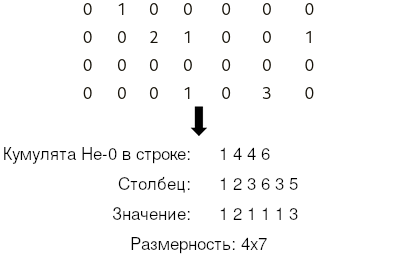



Здесь хранится информация о том, сколько суммарно ненулевых элементов в данной строке и выше, индексы столбцов с ненулевыми значениями, сами значения и размерность матрицы.

В первой строке обозначено, сколько накоплено ненулевых значений (в первой строке — суммарно 1, после второй строки — суммарно 4, после третьей строки — суммарно 4, после четвёртой строки — суммарно 6).
Во второй строке показано, в каком столбце находится ненулевое значение.
В третьей строке указаны сами значения.
Осуществляем преобразование следующим образом:

In [7]:
# Из-за этой ячейки падало Kernel

ratings_matrix = csr_matrix((ratings.rating,(ratings.user_id,ratings.book_id))) 

# Передаём в качестве аргументов в функцию выставленный рейтинг (это будут значения матрицы), 
# а также id пользователя и id книги (это будут индексы для строк и столбцов матрицы)

In [8]:
print(f"ratings_matrix.shape: {ratings_matrix.shape}")

ratings_matrix.shape: (53425, 10001)


Теперь нам необходимо составить матрицу с метаданными. В качестве индексов будут выступать id книги и id тега, и если у этой книги есть рассматриваемый тег, то на пересечении соответствующих строки и столбца будет выставлена единица.

In [9]:
meta_matrix = csr_matrix(([1]*len(book_tags),(book_tags['book_id'],book_tags['tag_id']))) 

In [10]:
print(f"meta_matrix.shape: {meta_matrix.shape}")
meta_matrix.shape

meta_matrix.shape: (10001, 33269)


(10001, 33269)

### Задание 4.4

1 point possible (graded)

Давайте проверим, что всё получилось правильно.

Каково среднее арифметическое значений разрежённой матрицы с рейтингами? Ответ округлите до трёх знаков после точки-разделителя.

## Решение задания 4.4


In [11]:
# Решение задания 4.4
# Вычисляем среднее арифметическое значений разрежённой матрицы с рейтингами

# Проверяем информацию о матрице
print("Информация о ratings_matrix:")
print(f"Размерность матрицы: {ratings_matrix.shape}")
print(f"Количество ненулевых элементов: {ratings_matrix.nnz}")
print(f"Общее количество элементов: {ratings_matrix.shape[0] * ratings_matrix.shape[1]}")

# Вычисляем среднее арифметическое значений разрежённой матрицы
# Для разреженной матрицы можно использовать метод .mean()
# или вычислить через сумму всех значений, деленную на количество ненулевых элементов
mean_rating = ratings_matrix.mean()

# Альтернативный способ (для проверки):
# mean_rating_alt = ratings_matrix.sum() / ratings_matrix.nnz

print(f"\nСреднее арифметическое значений матрицы (без округления): {mean_rating}")

# Округляем до трёх знаков после запятой
mean_rating_rounded = round(mean_rating, 3)

print("\n" + "="*60)
print("Ответ на вопрос задания:")
print(f"Среднее арифметическое значений разрежённой матрицы с рейтингами (округлено до 3 знаков): {mean_rating_rounded}")

# Дополнительная информация для проверки
print(f"\nДополнительная информация:")
print(f"- Сумма всех значений: {ratings_matrix.sum()}")
print(f"- Количество ненулевых элементов: {ratings_matrix.nnz}")
print(f"- Среднее (сумма/количество): {ratings_matrix.sum() / ratings_matrix.nnz}")


Информация о ratings_matrix:
Размерность матрицы: (53425, 10001)
Количество ненулевых элементов: 979478
Общее количество элементов: 534303425

Среднее арифметическое значений матрицы (без округления): 0.007086188900997592

Ответ на вопрос задания:
Среднее арифметическое значений разрежённой матрицы с рейтингами (округлено до 3 знаков): 0.007

Дополнительная информация:
- Сумма всех значений: 3786175
- Количество ненулевых элементов: 979478
- Среднее (сумма/количество): 3.8655028494769663


Отлично, данные подготовлены — теперь настало время определить модель, которую мы будем использовать. Сделаем это следующим образом:

In [12]:
rng = np.random.RandomState(42)

model = LightFM(
    loss='warp-kos', # Определяем функцию потерь
    random_state=rng, # Фиксируем случайное разбиение
    learning_rate=0.05, # Темп обучения
    no_components=100 # Размерность вектора для представления данных в модели
)

В качестве функции потерь мы выбрали значение 'warp', хотя, разумеется, это не единственный вариант. В модуле LightFM представлены следующие функции потерь:

- 'logistic' — логистическая функция. Полезна в случаях, когда есть как положительные, так и отрицательные взаимодействия, например 1 и -1.
- 'bpr' — байесовский персонализированный рейтинг. Можно применять, когда присутствуют только положительные взаимодействия.
- 'warp' — парный взвешенный приблизительный ранг. Используется, если необходимо повысить качество именно в верхней части списка рекомендаций.
- 'warp-kos' — модификация warp.

Разобьём данные на обучающую и тестовую выборки.


In [13]:
# # Создаем явный генератор случайных чисел
# # Это лечит краш "Access Violation" в Windows
rng = np.random.RandomState(42)

print("Начинаем разбиение выборки...")

train, test = random_train_test_split(
    ratings_matrix,      # Ваша sparse-матрица (уже с mapped ID)
    test_percentage=0.2, # Размер теста
    random_state=rng     # <--- ВАЖНО: Передаем объект rng, а не число 42
)

print(f"Разбиение завершено успешно!\nTrain shape: {train.shape}\nTest shape: {test.shape}")



# train, test = random_train_test_split(
#     ratings_matrix, # Общая выборка
#     test_percentage=0.2, # Размер тестовой выборки
#     random_state=42 # Генератор случайных чисел
# )

Начинаем разбиение выборки...


Разбиение завершено успешно!
Train shape: (53425, 10001)
Test shape: (53425, 10001)


Теперь обучим модель на наших данных о взаимодействии, также используя метаданные о книгах. Для этого воспользуемся методом fit(). В этот метод передадим обучающую выборку, признаки товаров — item_features, количество эпох обучения (сколько раз мы будем показывать модели исходный датасет, чтобы она лучше выучила данные) — epochs, а также параметр verbose для отслеживания процесса обучения:

In [14]:
model_fit = model.fit(
    train, # Обучающая выборка
    item_features=meta_matrix, # Признаки товаров
    epochs=10, # Количество эпох
    num_threads = 6, # Количество потоков
    verbose=True # Отображение обучения
)

Epoch: 100%|██████████| 10/10 [01:17<00:00,  7.74s/it]


In [15]:
prec_score = precision_at_k(
                     model_fit,
                     test,
                     item_features = meta_matrix).mean() 
print(prec_score)

0.022309788


0.023387857